In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
%%html
<style>table {float:center}</style>

## Extract events from the donation data

The data has the transactions codified under one column called 'appeal'.
Also, the charitable column indicates whether the transaction indicates whether or not a service was returned in return for the contribution.

The exercise in this notebook is to study this field to determine which appeals are campaigns and which are donations. Also, for the events, we want to establish an approximate date when the event took place.

We will add the following columns which have the following meanings:

Field|Data Type|Notes                                                        |
-----|--------|-------------------------------------------------------------|
is_service |boolean|Was a service returned in exchange for the contribution". We will seed it with the 'charitable' flag (charitable flag indicates whether or not a tax receipt was given) and change it based on more analysis.
channel|string|The primary marketing channel leading to this transaction. Possible values are TV, NL, Web, Volunteer, Mail, Radio. If nothing, it is set to 'Other'.

The data should look like this:

is_service      | channel  |
----------------|----------|
* **is_service=True** *|channel='Volunteer'
is_service=False|channel ='TV'
is_service=False|channel ='TV'
is_service=False|channel ='Web'
is_service=False|channel ='NL'
is_service=False|channel ='Radio'
is_service=False|...



#### Campaign Time:
Campaigns are volunteer intensive activities (like banquets, events, booths, etc). All campaigns have channel set to Volunteer and vice versa. Unlike other methods, they can only be targeted to a specific location at a specific time. Campaigns typically last for shorter durations (an year or less) .. with some caveats:  
   1. Some campaign names are re-used every year. So if the campaign contributions come in bins that are much farther apart, then that is usually an indication that they are two different campaigns.  
   2. Some campaigns get dwindling contributions that can be just an indication that volunteers have turned in the checks later. For example, an event can happen from June through August and still receive contributions in December that year. We can use the portion of the contributions that are part of the overall contributions spanning several months to determine if they are dwindling contributions and can be rounded off into the previous campaign or not.  
   3. Once we have identified which contributions go into which campaign/time, the amount/reach for the campaign is the total amount and number of donors that have attended the campaign. The time of the campaign is the date on which the campaign recieved the highest contributions.  

#### Process to identify campaigns from appeals:
Run this analysis only for data where is_service==True and channel=='Volunteer' to determine the different campaigns:  
1. Split each appeal into campaigns based on the date:
    * Aggregate transactions by month for each appeal code.  
    * If there are aggregations that are atmost two months apart, count them under the same campaign. If not, they are different campaigns. Use this to set a campaign_id.
2. Split the campaigns from step 1 further into smaller campaigns based on the location:
    * Group by zip code and assign the zipcode with the highest donor count to be a group.
    * For the subsequent group onwards, if the group is less than 100 miles from the an existing group, roll it into that one. Otherwise, create a new group. Keep going until we have covered 80% of the data. The remaining 20% inherit from the groups that are already there, no matter how far away they are.


In [32]:
df = pd.read_pickle('out/11/donations.pkl')

In [33]:
## Seed with the charitable flag
df["is_service"] = ~df.charitable

# Matching funds don't get receipts. But they are not services either.
df.loc[df.appeal.str.contains('matching', case=False), 'is_service'] = False
df.loc[df.appeal.str.contains('Fund', case=False), 'is_service'] = False

df.loc[df.appeal.str.contains('event', case=False), 'is_service'] = True

In [34]:
df["channel"] = np.nan

## Categorize as TV, Funds, Web, NL, Volunteer, Mail, etc
df.loc[pd.isnull(df.channel) & df.appeal.str.startswith('Ev_'), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.startswith('Event'), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.startswith('Booth'), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.startswith('Banquet'), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('Champion', case=False), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('Volunteer', case=False), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('AnilLal', case=False), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('DrRamani', case=False), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('Poker', case=False), 'channel'] = 'Volunteer'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('thankyou', case=False), 'channel'] = 'ThankYou'

df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_TV'), 'channel'] = 'TV'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_mail'), 'channel'] = 'Mail'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_AKKA2006_Mail'), 'channel'] = 'Mail'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_NL'), 'channel'] = 'NL'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_Internet'), 'channel'] = 'Web'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_Web'), 'channel'] = 'Web'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_Web_Groudspring'), 'channel'] = 'Web'
df.loc[pd.isnull(df.channel) & (df.appeal == 'Funds_Radio'), 'channel'] = 'Radio'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('matching', case=False), 'channel'] = 'Matching'
df.loc[pd.isnull(df.channel) & df.appeal.str.contains('payroll', case=False), 'channel'] = 'Payroll'

# If a service was provided, it must involve a volunteer. (Check with SEF on this)
df.loc[df.is_service==True, 'channel'] = 'Volunteer'

## This should be the last line since we are setting the default values
df.loc[pd.isnull(df.channel), 'channel'] = 'Other'

['Booth_Cricket_Sacramento' 'Funds_Cricket_SoCal' 'Event_SD_Cricket'
 'Event_Cricket_PA']


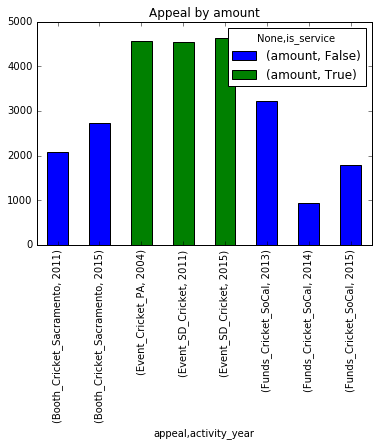

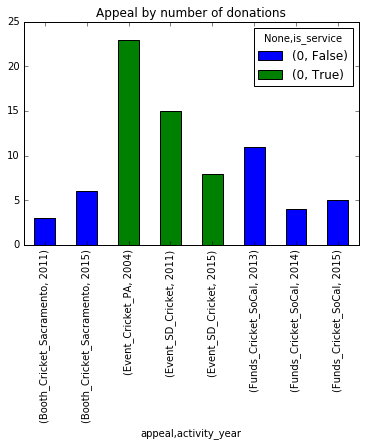

In [35]:
# This script for analyzing the results from the previous step (and revise it if need be)

print df[df.appeal.str.contains('cricket', case=False)].appeal.unique()
x = df[df.appeal.str.contains('cricket', case=False)]\
    .groupby(['appeal', 'activity_year', 'is_service']).amount.sum()\
    .sort_index(level='activity_year', ascending=True).to_frame()

x.unstack().fillna(0).plot(kind='bar', stacked=True, title='Appeal by amount')

x = df[df.appeal.str.contains('cricket', case=False)]\
    .groupby(['appeal', 'activity_year', 'is_service']).size()\
    .sort_index(level='activity_year', ascending=True).to_frame()

x.unstack().fillna(0).plot(kind='bar', stacked=True, title='Appeal by number of donations')

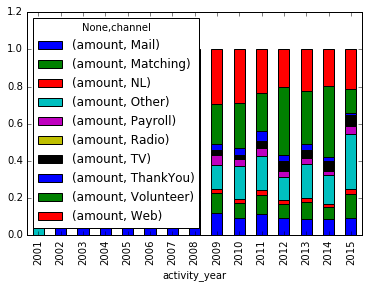

In [36]:
x = df\
    .groupby(['activity_year', 'channel']).amount.sum().to_frame().unstack().fillna(0)

y = x.apply(lambda x: x/sum(x), axis=1)
y.plot(kind='bar', stacked=True)

In [37]:
from haversine import haversine

def get_activity_locations(appeal_group):
    '''
    input: dataframe group for a single appeal that has a columns for zipcode, latitude, longitude, counts
    output: list of campaign groups ordered by the frequency of donors from that region that accounts for
    80% of the data. The other zipcodes are just assigned to campaign groups that are already created.
    '''
    maxiter = (appeal_group.shape[0] * 0.8)
    centers = list()
    locations = list()

    # Aggregate over each zipcode and iterate in the decreasing order of frequency of number of transactions
    for (zipcode, latitude, longitude), counts in \
        appeal_group\
        .groupby(['zipcode', 'latitude', 'longitude'])\
        .agg({'zipcode': np.size})\
        .sort_values(by='zipcode', ascending=False)\
        .itertuples():
        maxiter -= counts
        
        # Initialization
        if len(centers) == 0:
            target_campaign_id = 0
            centers.append([appeal_group.name, zipcode, target_campaign_id, latitude, longitude])
            is_center = True
        else:
            distances = [haversine((latitude, longitude), (c_lat, c_lon), miles=True)
                         for c_name, c_zipcode, c_campaign_id, c_lat, c_lon in centers]
            min_distance = distances[np.argmin(distances)]

            # create a new center if it is too far from existing centers and we haven't reached the limit,
            # else just use the closest center that we have
            if (maxiter > 0) and (min_distance > 150.0):
                target_campaign_id = len(centers)
                centers.append([appeal_group.name, zipcode, target_campaign_id, latitude, longitude])
                is_center = True
            # Otherwise, just use the closest center
            else:
                target_campaign_id = centers[np.argmin(distances)][2]
                is_center = (int(min_distance)==0)
        
        # Finally, record the location with the target campaign_id
        locations.append([appeal_group.name, zipcode, target_campaign_id, is_center])

    return locations

In [38]:
locations = df[(df.channel=='Volunteer') & (df.is_service==True)]\
    .groupby(['appeal'])[['zipcode', 'latitude', 'longitude']]\
    .apply(get_activity_locations)
campaign_locations = pd.DataFrame([item for sublist in locations.values for item in sublist],
                                  columns=['appeal', 'zipcode', 'campaign_location_id', 'is_location_center'])

In [39]:
print df[(df.channel=='Volunteer') & (df.is_service==True)][['appeal', 'zipcode']].drop_duplicates().shape
print campaign_locations.shape

(6409, 2)
(6409, 4)


In [40]:
df = df.merge(campaign_locations, how='left', on=['appeal', 'zipcode'])

In [41]:
def get_activity_months(appeal_group):
    '''
    input: dataframe group for a single appeal that has a columns for activity month.
    output: list of campaign groups ordered by the frequency of contiguous months that accounts for
    80% of the data. The other months are just assigned to campaign groups that are already created.
    '''
    maxiter = (appeal_group.shape[0] * 0.8)
    centers = list()
    months = list()

    # Aggregate over each month and iterate in the decreasing order of frequency of number of transactions
    for (activity_ym), counts in \
        appeal_group\
        .groupby(['activity_ym'])\
        .agg({'activity_ym': np.size})\
        .sort_values(by='activity_ym', ascending=False)\
        .itertuples():
        maxiter -= counts
        
        # Initialization
        if len(centers) == 0:
            target_campaign_id = len(centers)
            centers.append([appeal_group.name, activity_ym, target_campaign_id])
            is_center = True
        else:
            # Search for months that are contiguous to the current centers
            month_diffs = [abs(activity_ym - c_activity_ym)
                         for c_name, c_activity_ym, campaign_id in centers]
            min_diff = month_diffs[np.argmin(month_diffs)]

            # create a new center if it is too far from existing centers and we haven't reached the limit,
            # else just use the closest center that we have
            if (maxiter > 0) and (min_diff > 2):
                target_campaign_id = len(centers)
                centers.append([appeal_group.name, activity_ym, target_campaign_id])
                is_center = True
            # Otherwise, just use the closest center
            else:
                target_campaign_id = centers[np.argmin(month_diffs)][2]
                is_center = (min_diff==0)

        # Finally, record the location with the target campaign_id
        months.append([appeal_group.name, activity_ym, target_campaign_id, is_center])

    return months

In [42]:
months = df[(df.channel=='Volunteer') & (df.is_service==True)]\
    .groupby(['appeal'])[['activity_ym']]\
    .apply(get_activity_months)
campaign_months = pd.DataFrame([item for sublist in months.values for item in sublist],
                               columns=['appeal', 'activity_ym', 'campaign_month_id', 'is_month_center'])

In [43]:
print campaign_months.shape
print df[(df.channel=='Volunteer') & (df.is_service==True)][['appeal', 'activity_ym']].drop_duplicates().shape

(760, 4)
(760, 2)


In [44]:
df = df.merge(campaign_months, how='left', on=['appeal', 'activity_ym'])

In [45]:
# We only want to set the campaign_id on a subset of the data where it makes sense
print df.campaign_month_id.unique()
print df.campaign_location_id.unique()

[  2.  nan   0.   1.   3.   4.   5.   7.   6.]
[  0.  nan   1.   2.   4.   3.   6.  19.   5.  20.  16.  18.   8.  12.   7.
  13.  10.  17.  11.  14.  15.   9.]


In [46]:
df.columns

Index([u'activity_date', u'city', u'fund', u'batch_num', u'amount_initial',
       u'amount_cleanup', u'zipcode', u'longitude', u'sales', u'county',
       u'charitable', u'amount', u'state', u'donor_id', u'timezone',
       u'latitude', u'appeal', u'activity_year', u'activity_month',
       u'activity_dow', u'activity_ym', u'activity_yq', u'activity_ymd',
       u'county_norm', u'census_region_name', u'state_name', u'is_service',
       u'channel', u'campaign_location_id', u'is_location_center',
       u'campaign_month_id', u'is_month_center'],
      dtype='object')

In [47]:
# How many appeals got split into multiple campaign months
df[(df.is_service==True)].groupby('campaign_month_id').size()

campaign_month_id
0    19507
1     6254
2     2877
3     1926
4     1314
5      123
6       31
7       63
dtype: int64

In [48]:
# How many appeals got split into multiple campaign locations
df[(df.is_service==True)].groupby('campaign_location_id').size()

campaign_location_id
0     31130
1       486
2       174
3        91
4       106
5        47
6        14
7         1
8         3
9         2
10        1
11        1
12        1
13        2
14        2
15        1
16        1
17        1
18        2
19       11
20       18
dtype: int64

In [49]:
df[df.is_service==True].channel.unique()

array(['Volunteer'], dtype=object)

In [50]:
!mkdir -p out/21

In [51]:
df.to_pickle('out/21/donations.pkl')